In [83]:
##### import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from scipy import stats
from scipy.special import expit as logistic
from math import exp
from scipy.special import softmax
from quap import quap


RANDOM_SEED = 1448
np.random.seed(RANDOM_SEED)

Part 1. Theory

A company asks you to analyse some of their advertising and sales data to help them make marketing decisions. This company advertises their product in ads on Youtube videos. They would like to know whether longer running ads are more effective at getting people to click on their website relative to shorter ads. 

The dataset they send you has the following variables:

    click (yes/no): a variable indicating whether or not an individual has clicked on the ad.

    length (5 seconds – 1:30): a variable indicating the length of the advertisment video

    genre (kids, gaming, tech, building): a variable indicating which of 4 genres of Youtube video the advertisement was placed on

    user_ID: Many users viewed several different ads. This variable is a unique identifier for each user.

    budget (10_000 - 2_000_000): the budget per minute of the ad

    dark_theme: This variable indicates whether the user has their youtube set to Dark theme or Light theme.





###### What should your outcome variable be for this analysis?


The outcome variable should be the "click" variable because we want to know whether the probability of clicking on an ad depends on the length of the ad.

###### What family of model should you choose for this analysis, or in other words: what likelihood distribution should you assume for your outcome data, conditional on the independent variables?

The outcome variable is binary (0/1) so we should model it with a Binomial likelihood distribution with N=1

###### Does this model need a link function? Which? Why?

Yes, this model needs a logit link. We are modeling parameter p which is a probability and must therefore be between 0 and 1. The logit link can transform the linear component into a curve which is constrained between 0 and 1.

###### For the exam remember to also study the Poisson distribution and its associated link function (the log link).

###### What is the main predictor variable of interest? Is it a continuous or categorical variable? 

The main predictor variable is the length of the ad. It is a continuous variable.

###### Is there any reason to believe the relationship between this variable and the main (link-transformed) parameter will not be linear? If so, how might you model this non-linear relationship?

Yes, the effect of increasing ad length may have diminishing returns. There may also be an optimal ad length which is neither the longest or the shortest. to test this hypothesis I can include ad length squared as a predictor variable.

###### For each of the other variables in the dataset, please state: 

a)	are they categorical or continuous? 

b)	Could omitting them bias your estimate, and why?

c)	If they are categorical, should they be modeled using fixed or random effects? Explain why.

Name a possible interaction effect between the main predictor variable and one of the other independent variables that could be interesting to model.

genre: 

a)categorical variable. 

b) Yes, omitting this variable could bias the estimate, because the effect of longer or shorter ads could depend on the audience: if children have shorter attention spans, for instance, it may be more effective to have shorter ads on children's videos. If we ommit genre, we may not be able to see these effects.

c) This should be modeled as a fixed effect, because they are the only 4 genres that this company advertises on and are not drawn from a larger population of genres that the company could have selected

user_ID:

a)categorical variable. 

b) Yes, omitting this variable could bias the estimate, because data points from the same user are not independent from each other.

c) This should be modeled as a random effect, users can be thought of as randomly drawn from a larger population of potential users which we can model.
    
    

budget: 

a) continuous variable. 

b) Yes, omitting this variable could bias the estimate, because the company may have systematically spent more money on longer or shorter videos until now. We want to make sure we are measuring only the effect of ad length, and not the effect of the budget differences.

c) Not applicable since it is a continuous variable

  dark_theme:

a) categorical (binary) variable. 

b) No, this variable is irrelevant to our analysis because the theme preferences of the user is not important to their ad-clicking.

c) Not applicable (would be fixed effect if we included it)
    

##### Write the model definition for the model you have just proposed, leaving out the priors for the parameters (i.e. write just the likelihood line, the linear component, and any hyper-priors for random effects).

	click ~ Binomial (1,p)
    
	logit(p) = a[user_ID] + b1[genre] + b2*length + b3*budget
    
	a[user_ID] ~ Normal(alpha,sigma)


##### Part 2. Simulation


Simulate a dataset of 192 observations of 3 variables: 2 independent variables X1 and X2, and 1 dependent variable Y.


In [84]:
N = 192

X1 is normally distributed, with mean 0 and standard deviation 1.


In [85]:
x1 = np.random.normal(0, 1, N)

X2 is log-normally distributed, with mu =  0 and sigma = 1

In [86]:
x2 = np.random.lognormal(0, 1, N)

Y is a distributed normally around a mean mu = -1 -0.002*X1 + 0.57*X2. The residual standard error of Y conditional on X1 and X2 is 2.

In [87]:
y = np.random.normal(-1-0.002*x1 + 0.57*x2, 2)

Run a linear regression using Quap and attempt to recover the simulated parameters. 

In [88]:
with pm.Model() as model_part2:
    a = pm.Normal("a",0,5)
    b1 = pm.Normal("b1",0,1)
    b2 = pm.Normal("b2",0,1)
    sigma = pm.Exponential("sigma",1)
    mu = a + b1*x1 + b2*x2
    
    y_hat = pm.Normal("y_hat",mu,sigma, observed = y)
    
    idata, dist = quap(vars=[a,b1,b2,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)
    

In [89]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.864,0.180,-1.145,-0.572
b1,0.085,0.147,-0.155,0.310
b2,0.606,0.077,0.480,0.725
sigma,1.945,0.100,1.792,2.108


Next, plot the predicted effect of x2 on Y, holding x1 at 0. Plot a 95% highest density interval around the predicted mean and a 95% prediction interval for the data.

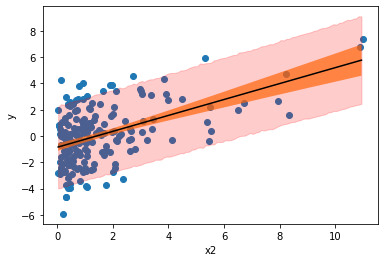

In [93]:
x2_seq = np.arange(x2.min(), x2.max(), step=0.1)

mu_pred = np.zeros((len(x2_seq), len(samples)))
y_pred = np.zeros((len(x2_seq), len(samples)))

# We set traffic mortality at some counterfactual value, e.g the mean

for i, w in enumerate(x2_seq):
    mu_pred[i] = samples["a"] + samples["b1"] * 0 + samples["b2"] *w
    y_pred[i] = np.random.normal(mu_pred[i], samples["sigma"])

plt.scatter(x2, y)
plt.plot(x2_seq, mu_pred.mean(1), "k")
plt.fill_between(x2_seq, np.quantile(mu_pred,0.055,axis=1), np.quantile(mu_pred,0.945,axis=1), alpha=0.7)
plt.fill_between(x2_seq, np.quantile(y_pred,0.055,axis=1), np.quantile(y_pred,0.945,axis=1), alpha=0.2,color='red')
plt.xlabel("x2")
plt.ylabel("y")
plt.show()

### Part 3. Data


The chimpanzees.csv dataset is drawn from experiments designed to test whether chimpanzees choose to help out random other chimps at no cost to themselves. (See chapter 11/12 and lectures for week 10 and 11 for description of experiment. In the main exam you will have a more detailed description of the dataset).

In [2]:
d = pd.read_csv("Data/chimpanzees.csv")
d.head()


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


Fit the following model in pymc3 using pm.sample:

	PulledLeft ~ Binomial (1,p)
    
	logit(p) = a[actor] + b1*ProsocialLeft + b2[ProsocialLeft] * OtherPresent
    
	a[actor] ~ Normal (0, 1.5)
    
	b1 ~ Normal (0,1)
    
    b2[ProsocialLeft] ~ Normal (0, 0.5)
    
    


In [3]:
with pm.Model() as chimp_model_fixed:
    a = pm.Normal("a", 0, 1.5, shape=d.actor.nunique())
    b1 = pm.Normal("b1",0,1)
    b2 = pm.Normal("b2",0,0.5, shape=2)
    
    p = pm.Deterministic("p", pm.math.invlogit(a[d.actor-1] + b1*d.prosoc_left + b2[d.prosoc_left]*d.condition))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    post_fix = pm.sample(random_seed=RANDOM_SEED,draws=10_000,return_inferencedata=True)
    post_fix_dat = az.InferenceData.to_dataframe(post_fix)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2, b1, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 172 seconds.


Present the b1 and b2 parameters in a forest plot and interpret their meaning.

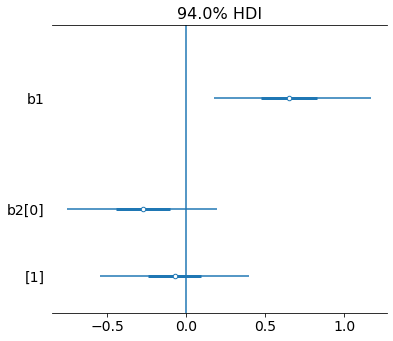

In [6]:
az.plot_forest(post_fix, var_names=["b1","b2"], combined=True)
plt.axvline(0)

Interpretation: b1 is the main effect of having the "prosocial" option on the left. Chimpanzees tended to select the "prosocial" option more often even in the absence of a partner.

the b2 parameters are the effects of having a chimpanzee partner on the probability of pulling the left lever, depending on whether the prosocial option was on the right (b2[0]) or the left (b2[1]). In both cases having a partner made chimps slightly less likely to pull the left lever, but not significantly. This is consistent with chimpanzees having no "prosocial preference".

Next, rerun the same model but with actor as a random effect rather than a fixed effect. 

In [7]:
with pm.Model() as chimp_model_random:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    a_sigma = pm.Exponential("a_sigma", 1.0)
    a = pm.Normal("a", a_bar, a_sigma, shape=d.actor.nunique())
    b1 = pm.Normal("b1",0,1)
    b2 = pm.Normal("b2",0,1, shape=2)
    
    p = pm.Deterministic("p", pm.math.invlogit(a[d.actor-1] + b1*d.prosoc_left + b2[d.prosoc_left]*d.condition))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    post_rand = pm.sample(random_seed=RANDOM_SEED,draws=10_000,return_inferencedata=True, target_accept=0.99)
    post_rand_dat = az.InferenceData.to_dataframe(post_fix)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2, b1, a, a_sigma, a_bar]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1892 seconds.


Compare the fixed and random effects models using WAIC or Leave One Out cross-validation. Which is the most effective model?

In [94]:
az.compare({"Fixed effects":post_fix,
            "Random effects":post_rand}, scale="deviance")

C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Fixed effects,0,531.295954,8.156153,0.000000,0.574567,19.190135,0.000000,False,deviance
Random effects,1,531.331021,8.813251,0.035067,0.425433,19.537503,0.953408,False,deviance


Both models are almost equally effective. Leave-one-out cross validation gives a slight edge to the fixed effect model, although both could be used.